Test MSE: 0.87585


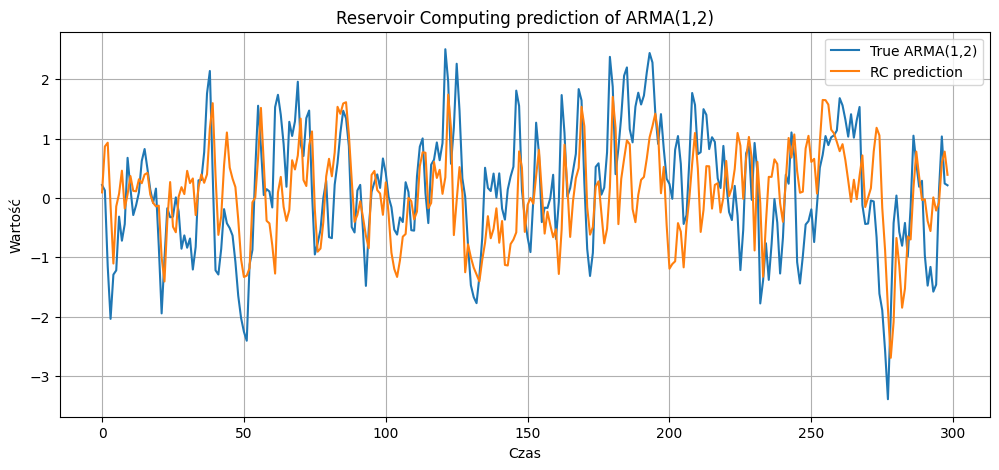

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from scipy.signal import lfilter

# ======== 1. Generuj dane z ARMA(1,2) ============
np.random.seed(42)

N = 1000  # długość serii
ar = np.array([1, -0.7])  # AR(1): x_t = 0.7*x_{t-1}
ma = np.array([1, 0.5, -0.3])  # MA(2): + 0.5*e_{t-1} - 0.3*e_{t-2}
noise = np.random.normal(0, 1, N)

# Generujemy dane ARMA
data = lfilter(ma, ar, noise)

# Normalizacja
data = (data - np.mean(data)) / np.std(data)

# ======== 2. Parametry RC ========================
input_size = 1
reservoir_size = 100
spectral_radius = 0.9
sparsity = 0.1
leak_rate = 0.3
ridge_lambda = 1e-6

train_len = 700
test_len = N - train_len - 1

# ======== 3. Inicjalizacja wag ================
Win = (np.random.rand(reservoir_size, input_size) - 0.5) * 2
Wres = np.random.rand(reservoir_size, reservoir_size) - 0.5

# Sparsify i ustal promień spektralny
Wres[np.random.rand(*Wres.shape) > sparsity] = 0
eigvals = np.linalg.eigvals(Wres)
Wres *= spectral_radius / np.max(np.abs(eigvals))

# ======== 4. Napędzanie rezerwuaru ============
reservoir_states = np.zeros((train_len, reservoir_size))
r = np.zeros(reservoir_size)

for t in range(train_len):
    u = data[t]
    preactivation = np.dot(Win, [u]) + np.dot(Wres, r)
    r = (1 - leak_rate) * r + leak_rate * np.tanh(preactivation)
    reservoir_states[t] = r

# ======== 5. Trening readoutu ==================
Y_target = data[1:train_len+1]  # przewidujemy x(t+1)

# Ridge regression
R = reservoir_states.T
Wout = np.dot(Y_target, R.T) @ np.linalg.inv(R @ R.T + ridge_lambda * np.eye(reservoir_size))

# ======== 6. Testowanie modelu =================
Y_pred = []
r_test = r.copy()

for t in range(train_len, train_len + test_len):
    u = data[t]
    preactivation = np.dot(Win, [u]) + np.dot(Wres, r_test)
    r_test = (1 - leak_rate) * r_test + leak_rate * np.tanh(preactivation)
    y = np.dot(Wout, r_test)
    Y_pred.append(y)

Y_true = data[train_len+1:train_len + test_len + 1]

# ======== 7. Ewaluacja =========================
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(Y_true, Y_pred)

print(f"Test MSE: {mse:.5f}")

# ======== 8. Wykres ============================
plt.figure(figsize=(12, 5))
plt.plot(Y_true, label="True ARMA(1,2)")
plt.plot(Y_pred, label="RC prediction")
plt.title("Reservoir Computing prediction of ARMA(1,2)")
plt.xlabel("Czas")
plt.ylabel("Wartość")
plt.legend()
plt.grid(True)
plt.show()

### Training the readout layer with momentum

To accelerate convergence and stabilize the optimization of the readout weights $ \mathbf{W}_{\text{out}} $, we can incorporate **momentum** into the gradient descent procedure. Momentum helps the optimization escape shallow local minima and smooths the update trajectory by accumulating a velocity vector in parameter space.

The update rule for the weights at iteration $ k $ is:

$$
\begin{aligned}
\mathbf{v}_{k+1} &= \mu \mathbf{v}_k - \eta \nabla \mathcal{L}(\mathbf{W}_{\text{out},k}) \\
\mathbf{W}_{\text{out},k+1} &= \mathbf{W}_{\text{out},k} + \mathbf{v}_{k+1}
\end{aligned}
$$

where:
- $ \mathbf{v}_k $ is the velocity vector at iteration $ k $, initialized as zero,
- $ \mu \in [0,1) $ is the **momentum coefficient** (typical values are around 0.9),
- $ \eta > 0 $ is the learning rate,
- $ \nabla \mathcal{L}(\mathbf{W}_{\text{out},k}) $ is the gradient of the loss function with respect to $ \mathbf{W}_{\text{out}} $ at iteration $ k $.

The loss function remains the ridge-regularized mean squared error:

$$
\mathcal{L}(\mathbf{W}_{\text{out}}) = \| \mathbf{Y} - \mathbf{W}_{\text{out}} \mathbf{R} \|_F^2 + \lambda \| \mathbf{W}_{\text{out}} \|_F^2,
$$

with $ \lambda \geq 0 $ being the regularization coefficient.

Using momentum effectively accelerates training, especially in cases where the loss surface has flat or elongated valleys. Additionally, gradient clipping can be applied to keep updates stable by preventing excessively large gradient steps.


Epoch 1/500, Loss: 2.798418
Epoch 101/500, Loss: 1.743766
Epoch 201/500, Loss: 1.583606
Epoch 301/500, Loss: 1.517354
Epoch 401/500, Loss: 1.480883
Epoch 500/500, Loss: 1.455007
Final MSE: 1.453430


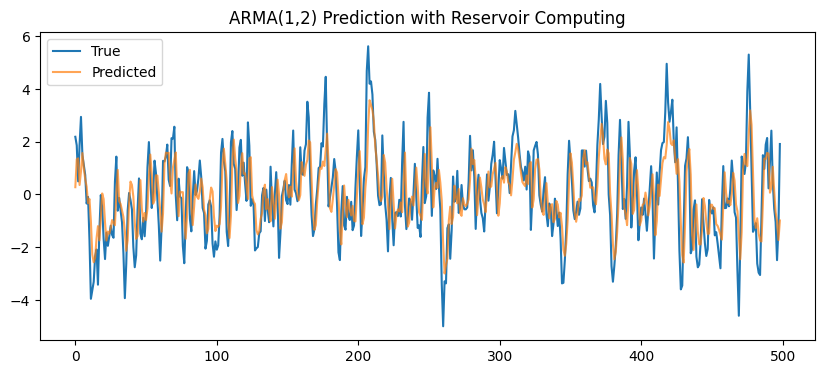

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Generowanie danych ARMA(1,2) ---
np.random.seed(42)
T = 500
phi = 0.7
theta1, theta2 = 0.5, -0.3
noise = np.random.normal(0, 1, T + 2)

y = np.zeros(T + 2)
for t in range(2, T + 2):
    y[t] = phi * y[t-1] + noise[t] + theta1 * noise[t-1] + theta2 * noise[t-2]
y = y[2:]

# --- Rezerwuar ---
N = 100
input_dim = 1
alpha = 0.9
leak_rate = 0.3

Win = (np.random.rand(N, input_dim) - 0.5) * 1
Wres = np.random.rand(N, N) - 0.5
mask = np.random.rand(N, N) < 0.1
Wres *= mask
eigvals = np.linalg.eigvals(Wres)
rho = max(abs(eigvals))
Wres *= alpha / rho

def f(x):
    return np.tanh(x)

def update_reservoir(r, u):
    return (1 - leak_rate) * r + leak_rate * f(Win @ u + Wres @ r)

inputs = y[:-1].reshape(1, -1)
targets = y[1:].reshape(1, -1)
T_train = inputs.shape[1]

R = np.zeros((N, T_train))
r = np.zeros(N)

for t in range(T_train):
    u = inputs[:, t]
    r = update_reservoir(r, u)
    R[:, t] = r

# --- Trening z momentum ---
Wout = np.zeros((1, N))
velocity = np.zeros_like(Wout)
learning_rate = 1e-4
momentum = 0.9
lambda_reg = 1e-4
epochs = 500
max_grad_norm = 10.0

for epoch in range(epochs):
    Y_pred = Wout @ R
    grad = -2 * (targets - Y_pred) @ R.T + 2 * lambda_reg * Wout

    grad_norm = np.linalg.norm(grad)
    if grad_norm > max_grad_norm:
        grad = grad * (max_grad_norm / grad_norm)

    velocity = momentum * velocity - learning_rate * grad
    Wout += velocity

    if epoch % 100 == 0 or epoch == epochs - 1:
        loss = np.mean((targets - Y_pred) ** 2) + lambda_reg * np.sum(Wout ** 2)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")

# --- Finalne predykcje i wykres ---
Y_pred = Wout @ R
mse = np.mean((targets - Y_pred) ** 2)
print(f"Final MSE: {mse:.6f}")

plt.figure(figsize=(10,4))
plt.plot(targets.flatten(), label="True")
plt.plot(Y_pred.flatten(), label="Predicted", alpha=0.7)
plt.title("ARMA(1,2) Prediction with Reservoir Computing")
plt.legend()
plt.show()

[Simple] Epoch 1/500, Loss: 2.798423
[Simple] Epoch 101/500, Loss: 1.618171
[Simple] Epoch 201/500, Loss: 1.565054
[Simple] Epoch 301/500, Loss: 1.536746
[Simple] Epoch 401/500, Loss: 1.517516
[Simple] Epoch 500/500, Loss: 1.503636
[Momentum] Epoch 1/500, Loss: 2.798418
[Momentum] Epoch 101/500, Loss: 1.745939
[Momentum] Epoch 201/500, Loss: 1.584826
[Momentum] Epoch 301/500, Loss: 1.513147
[Momentum] Epoch 401/500, Loss: 1.471409
[Momentum] Epoch 500/500, Loss: 1.444095
Final MSE Simple: 1.502961
Final MSE Momentum: 1.442451


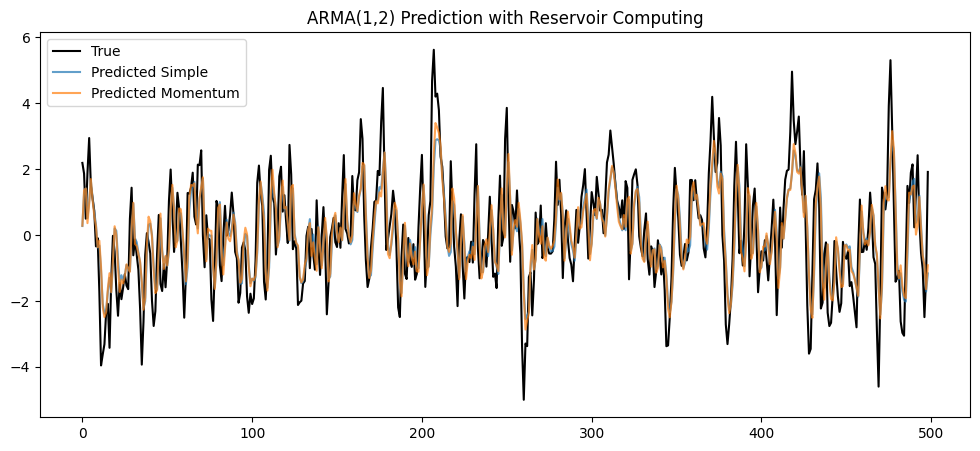

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- Generowanie danych ARMA(1,2) ---
def generate_arma_data(T=500, phi=0.7, theta1=0.5, theta2=-0.3, seed=42):
    np.random.seed(seed)
    noise = np.random.normal(0, 1, T + 2)
    y = np.zeros(T + 2)
    for t in range(2, T + 2):
        y[t] = phi * y[t-1] + noise[t] + theta1 * noise[t-1] + theta2 * noise[t-2]
    return y[2:]

# --- Budowanie rezerwuaru ---
def build_reservoir(N=100, input_dim=1, alpha=0.9, leak_rate=0.3, seed=42):
    np.random.seed(seed)
    Win = (np.random.rand(N, input_dim) - 0.5) * 1
    Wres = np.random.rand(N, N) - 0.5
    mask = np.random.rand(N, N) < 0.1  # 10% sparsity
    Wres *= mask
    eigvals = np.linalg.eigvals(Wres)
    rho = max(abs(eigvals))
    Wres *= alpha / rho
    return Win, Wres, leak_rate

# --- Aktualizacja stanu rezerwuaru ---
def update_reservoir(r, u, Win, Wres, leak_rate):
    return (1 - leak_rate) * r + leak_rate * np.tanh(Win @ u + Wres @ r)

# --- Zbieranie stanów ---
def collect_states(inputs, Win, Wres, leak_rate):
    N = Win.shape[0]
    T = inputs.shape[1]
    r = np.zeros(N)
    R = np.zeros((N, T))
    for t in range(T):
        u = inputs[:, t]
        r = update_reservoir(r, u, Win, Wres, leak_rate)
        R[:, t] = r
    return R

# --- Trening bez momentum ---
def train_simple_gradient(Wout, R, targets, epochs=500, lr=1e-4, lambda_reg=1e-4):
    for epoch in range(epochs):
        Y_pred = Wout @ R
        grad = -2 * (targets - Y_pred) @ R.T + 2 * lambda_reg * Wout
        Wout -= lr * grad
        if epoch % 100 == 0 or epoch == epochs - 1:
            loss = np.mean((targets - Y_pred) ** 2) + lambda_reg * np.sum(Wout ** 2)
            print(f"[Simple] Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
    return Wout

# --- Trening z momentum ---
def train_momentum(Wout, R, targets, epochs=500, lr=1e-4, lambda_reg=1e-4, momentum=0.9, max_grad_norm=10.0):
    velocity = np.zeros_like(Wout)
    for epoch in range(epochs):
        Y_pred = Wout @ R
        grad = -2 * (targets - Y_pred) @ R.T + 2 * lambda_reg * Wout
        grad_norm = np.linalg.norm(grad)
        if grad_norm > max_grad_norm:
            grad = grad * (max_grad_norm / grad_norm)
        velocity = momentum * velocity - lr * grad
        Wout += velocity
        if epoch % 100 == 0 or epoch == epochs - 1:
            loss = np.mean((targets - Y_pred) ** 2) + lambda_reg * np.sum(Wout ** 2)
            print(f"[Momentum] Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
    return Wout

# --- Główna część ---
def main():
    # Dane
    y = generate_arma_data()
    inputs = y[:-1].reshape(1, -1)
    targets = y[1:].reshape(1, -1)

    # Rezerwuar
    Win, Wres, leak_rate = build_reservoir()

    # Zbieranie stanów
    R = collect_states(inputs, Win, Wres, leak_rate)

    # Inicjalizacja wag wyjściowych
    N = Win.shape[0]
    Wout_simple = np.zeros((1, N))
    Wout_momentum = np.zeros((1, N))

    # Trening
    Wout_simple = train_simple_gradient(Wout_simple, R, targets)
    Wout_momentum = train_momentum(Wout_momentum, R, targets)

    # Predykcje
    Y_pred_simple = Wout_simple @ R
    Y_pred_momentum = Wout_momentum @ R

    mse_simple = np.mean((targets - Y_pred_simple) ** 2)
    mse_momentum = np.mean((targets - Y_pred_momentum) ** 2)

    print(f"Final MSE Simple: {mse_simple:.6f}")
    print(f"Final MSE Momentum: {mse_momentum:.6f}")

    # Wykres
    plt.figure(figsize=(12,5))
    plt.plot(targets.flatten(), label="True", color="black")
    plt.plot(Y_pred_simple.flatten(), label="Predicted Simple", alpha=0.7)
    plt.plot(Y_pred_momentum.flatten(), label="Predicted Momentum", alpha=0.7)
    plt.title("ARMA(1,2) Prediction with Reservoir Computing")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()

# new data
Jacob


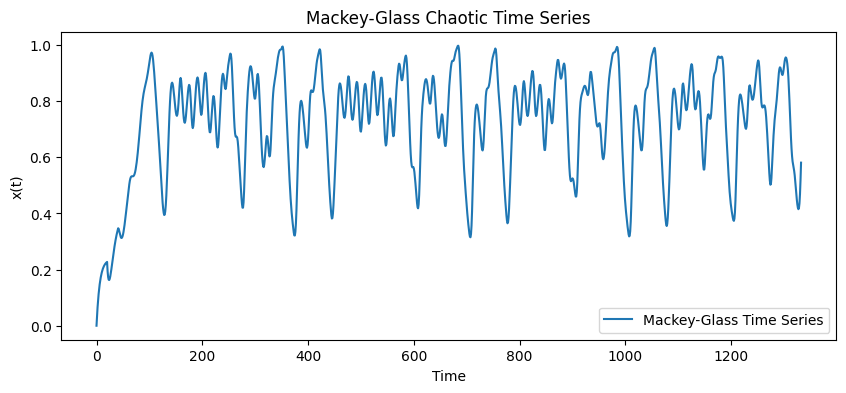

In [7]:
import numpy as np
import matplotlib.pyplot as plt

### Simulates the Mackey-Glass time series using the 4th-order Runge-Kutta method.
#   As the result will be generated from quantum measurement, we need to scale it to [0..1]
def mackey_glass(beta=0.2, gamma=0.1, n=10, tau=17, dt=0.1, T=1000):
    
    N = int(T / dt)                # Total number of time steps
    delay_steps = int(tau / dt)    # Delay in terms of steps
    x = np.zeros(N + delay_steps)  # Initialize time series with zeros
    x[0:delay_steps] = 1.2         # Initial condition

    for t in range(delay_steps, N + delay_steps - 1):
        x_tau = x[t - delay_steps]  # Delayed term
        dxdt = beta * x_tau / (1 + x_tau**n) - gamma * x[t]  # Mackey-Glass equation
        x[t + 1] = x[t] + dxdt * dt  # Euler integration

    x_min, x_max = np.min(x), np.max(x)
    x = (x - x_min) / (x_max - x_min)

    return x[delay_steps:]  # Return only the valid part of the time series

# Generate and plot the Mackey-Glass time series
# time_series = mackey_glass(dt=1, T=2000)
time_series = mackey_glass(beta=0.17, dt=1.5, T=2000, tau=30)

plt.figure(figsize=(10, 4))
plt.plot(time_series, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

In [8]:
time_series

array([0.        , 0.03545736, 0.06559612, ..., 0.46878683, 0.51884477,
       0.58069002])

[Momentum] Epoch 1/500, Loss: 0.559653
[Momentum] Epoch 101/500, Loss: 0.004114
[Momentum] Epoch 201/500, Loss: 0.001550
[Momentum] Epoch 301/500, Loss: 0.001334
[Momentum] Epoch 401/500, Loss: 0.001216
[Momentum] Epoch 500/500, Loss: 0.001128
Final MSE Momentum: 0.001034


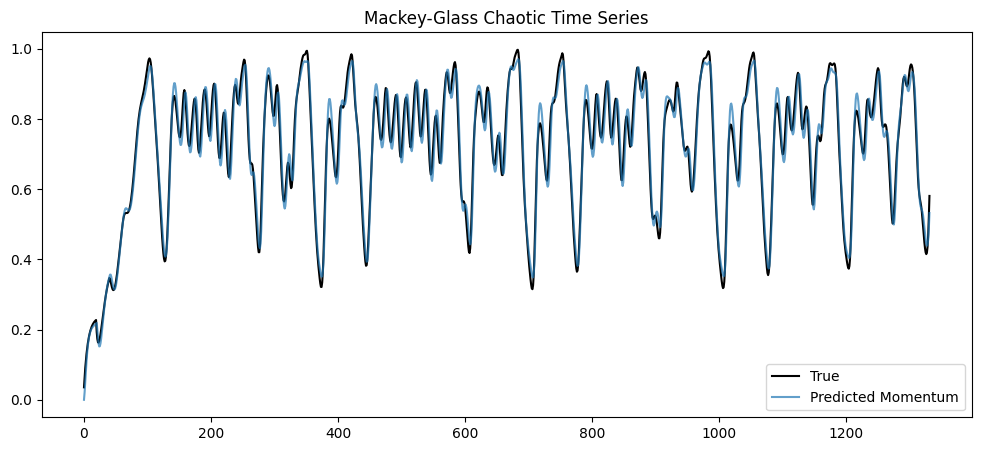

In [11]:
def main():
    # Dane
    y = time_series
    inputs = y[:-1].reshape(1, -1)
    targets = y[1:].reshape(1, -1)

    # Rezerwuar
    Win, Wres, leak_rate = build_reservoir()

    # Zbieranie stanów
    R = collect_states(inputs, Win, Wres, leak_rate)

    # Inicjalizacja wag wyjściowych
    N = Win.shape[0]
    Wout_momentum = np.zeros((1, N))

    # Trening
    Wout_momentum = train_momentum(Wout_momentum, R, targets)

    # Predykcje
    Y_pred_momentum = Wout_momentum @ R

    mse_momentum = np.mean((targets - Y_pred_momentum) ** 2)

    print(f"Final MSE Momentum: {mse_momentum:.6f}")

    # Wykres
    plt.figure(figsize=(12,5))
    plt.plot(targets.flatten(), label="True", color="black")
    plt.plot(Y_pred_momentum.flatten(), label="Predicted Momentum", alpha=0.7)
    plt.title("Mackey-Glass Chaotic Time Series")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()